In [216]:
from tensorflow import keras
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
import os

In [217]:
file_list = os.listdir('./results/')
n_res = len(file_list)

In [218]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
    
    phi += 0.01*np.random.rand(phi.shape[0])
    theta += 0.01*np.random.rand(theta.shape[0])
    
#     phi = np.roll(phi, -1)
#     theta = np.roll(theta, -1)
#     psi = np.roll(psi, -1)
    
#     phi = phi[:-1]
#     theta = theta[:-1]
#     u_tilde = u_tilde[:-1]
#     psi = psi[:-1]
#     E_0 = E_0[:-1]
#     v_0 = v_0[:-1]

    nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [219]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

In [259]:
y_scaling = pd.concat(nn_output_train).abs().max().to_numpy()
x_scaling = pd.concat(nn_input_train).abs().max().to_numpy()

In [260]:
y_scaling

array([ 1.23330859,  1.32089976,  3.14416398,  9.99981034,  7.25518541,
       15.48465048])

In [261]:
n_datasets = len(nn_input_train)
seq_length = 10  # length of sequence for ANN training

n_data = nn_input_train[0].shape[0]
n_seq = (n_data // seq_length) - 1

# create sequences from the data:
X = []
Y = []
# for data_i in range(n_datasets):
#     X_train = nn_input_train[data_i].to_numpy()
#     Y_train = nn_output_train[data_i].to_numpy()
#     for offset in range(seq_length):
#         for data_sample in range(n_seq-1):
#             start_ind = data_sample*seq_length+offset
#             X.append(X_train[start_ind:start_ind + seq_length, :])
#             Y.append(Y_train[start_ind:start_ind + seq_length, :])

for data_sample in range(n_seq):
    for data_i in range(n_datasets):
        X_train = nn_input_train[data_i].to_numpy()
        Y_train = nn_output_train[data_i].to_numpy()
        for offset in range(seq_length):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :]/x_scaling)
            Y.append(Y_train[start_ind:start_ind + seq_length, :]/y_scaling)

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = seq_length*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [262]:
batch_size

150

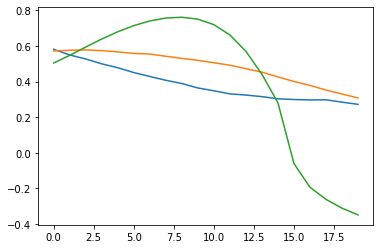

In [263]:
n= 15
plt.plot(np.concatenate((X[0+n],X[batch_size+n])))

We obtain the following training data shape:

In [264]:
X.shape

(10350, 10, 3)

Note that with the batch_size:

In [265]:
batch_size

150

WE obtain

In [266]:
X.shape[0]/batch_size

69.0

consecutive sequences for each batch.

# Create RNN:

In [267]:
def get_model(model_param, nx, ny, batch_size, seq_length, stateful=True, return_sequences=True):
    n_a = model_param['RNN_param']['n_activation']

    implementation_mode = model_param['RNN_param']['implementation']

    model = keras.models.Sequential()
    if 'SimpleRNN' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.SimpleRNN(n_a, input_shape=(seq_length, nx), batch_size=batch_size,
                                         return_sequences=return_sequences, stateful=stateful))
    elif 'GRU' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.GRU(n_a, input_shape=(seq_length, nx), recurrent_activation='sigmoid', batch_size=batch_size,
                                   return_sequences=return_sequences, stateful=stateful, implementation=implementation_mode))
    elif 'LSTM' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.LSTM(n_a, input_shape=(seq_length, nx), recurrent_activation='sigmoid', batch_size=batch_size,
                                    return_sequences=return_sequences, stateful=stateful, implementation=implementation_mode))

    for units, activation in zip(model_param['n_units'], model_param['activation']):
        model.add(keras.layers.TimeDistributed(keras.layers.Dense(units, activation=activation)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(ny, activation='linear')))
    return model

In [268]:
stateful = True
n_layer = 3  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [20]
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 20
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (150, 10, 20)             1920      
_________________________________________________________________
time_distributed_88 (TimeDis (150, 10, 20)             420       
_________________________________________________________________
time_distributed_89 (TimeDis (150, 10, 20)             420       
_________________________________________________________________
time_distributed_90 (TimeDis (150, 10, 20)             420       
_________________________________________________________________
time_distributed_91 (TimeDis (150, 10, 6)              126       
Total params: 3,306
Trainable params: 3,306
Non-trainable params: 0
_________________________________________________________________


In [269]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

history = model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=500, verbose=1, shuffle=False)

Train on 10350 samples
Epoch 1/500
10350/10350 [==============================] - 2s 150us/sample - loss: 0.1558
Epoch 2/500
10350/10350 [==============================] - 1s 57us/sample - loss: 0.0188
Epoch 3/500
10350/10350 [==============================] - 1s 49us/sample - loss: 0.0114
Epoch 4/500
10350/10350 [==============================] - 0s 44us/sample - loss: 0.0088
Epoch 5/500
10350/10350 [==============================] - 1s 57us/sample - loss: 0.0075
Epoch 6/500
10350/10350 [==============================] - 1s 48us/sample - loss: 0.0066
Epoch 7/500
10350/10350 [==============================] - 1s 50us/sample - loss: 0.0061
Epoch 8/500
10350/10350 [==============================] - 0s 48us/sample - loss: 0.0057
Epoch 9/500
10350/10350 [==============================] - 1s 50us/sample - loss: 0.0055
Epoch 10/500
10350/10350 [==============================] - 0s 47us/sample - loss: 0.0054
Epoch 11/500
10350/10350 [==============================] - 0s 47us/sample - loss: 0.

10350/10350 [==============================] - 0s 41us/sample - loss: 0.0019
Epoch 92/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0019
Epoch 93/500
10350/10350 [==============================] - 0s 39us/sample - loss: 0.0019
Epoch 94/500
10350/10350 [==============================] - 0s 39us/sample - loss: 0.0019
Epoch 95/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0019
Epoch 96/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0019
Epoch 97/500
10350/10350 [==============================] - 0s 41us/sample - loss: 0.0019
Epoch 98/500
10350/10350 [==============================] - 0s 39us/sample - loss: 0.0018
Epoch 99/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0018
Epoch 100/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0018
Epoch 101/500
10350/10350 [==============================] - 0s 41us/sample - loss: 0.0018
Epoch 102/500
10350/1

10350/10350 [==============================] - 0s 42us/sample - loss: 0.0012
Epoch 182/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0012
Epoch 183/500
10350/10350 [==============================] - 0s 39us/sample - loss: 0.0012
Epoch 184/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0012
Epoch 185/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0012
Epoch 186/500
10350/10350 [==============================] - 0s 39us/sample - loss: 0.0012
Epoch 187/500
10350/10350 [==============================] - 0s 40us/sample - loss: 0.0012
Epoch 188/500
10350/10350 [==============================] - 1s 49us/sample - loss: 0.0012
Epoch 189/500
10350/10350 [==============================] - 0s 42us/sample - loss: 0.0012
Epoch 190/500
10350/10350 [==============================] - 0s 42us/sample - loss: 0.0012
Epoch 191/500
10350/10350 [==============================] - 0s 44us/sample - loss: 0.0012
Epoch 192/500

10350/10350 [==============================] - 0s 41us/sample - loss: 9.5015e-04
Epoch 271/500
10350/10350 [==============================] - 0s 41us/sample - loss: 9.4799e-04
Epoch 272/500
10350/10350 [==============================] - 0s 41us/sample - loss: 9.4619e-04
Epoch 273/500
10350/10350 [==============================] - 0s 41us/sample - loss: 9.4399e-04
Epoch 274/500
10350/10350 [==============================] - 0s 43us/sample - loss: 9.4249e-04
Epoch 275/500
10350/10350 [==============================] - 0s 41us/sample - loss: 9.4015e-04
Epoch 276/500
10350/10350 [==============================] - 0s 41us/sample - loss: 9.3927e-04
Epoch 277/500
10350/10350 [==============================] - 0s 41us/sample - loss: 9.3678e-04
Epoch 278/500
10350/10350 [==============================] - 0s 40us/sample - loss: 9.3759e-04
Epoch 279/500
10350/10350 [==============================] - 0s 42us/sample - loss: 9.3620e-04
Epoch 280/500
10350/10350 [==============================] - 0s 

10350/10350 [==============================] - 0s 41us/sample - loss: 8.1693e-04
Epoch 357/500
10350/10350 [==============================] - 0s 41us/sample - loss: 7.9792e-04
Epoch 358/500
10350/10350 [==============================] - 0s 41us/sample - loss: 8.1492e-04
Epoch 359/500
10350/10350 [==============================] - 0s 41us/sample - loss: 7.9466e-04
Epoch 360/500
10350/10350 [==============================] - 0s 41us/sample - loss: 8.1330e-04
Epoch 361/500
10350/10350 [==============================] - 0s 41us/sample - loss: 7.9168e-04
Epoch 362/500
10350/10350 [==============================] - 0s 41us/sample - loss: 8.1198e-04
Epoch 363/500
10350/10350 [==============================] - 0s 44us/sample - loss: 7.8894e-04
Epoch 364/500
10350/10350 [==============================] - 0s 40us/sample - loss: 8.1074e-04
Epoch 365/500
10350/10350 [==============================] - 0s 41us/sample - loss: 7.8636e-04
Epoch 366/500
10350/10350 [==============================] - 0s 

10350/10350 [==============================] - 0s 44us/sample - loss: 7.0811e-04
Epoch 443/500
10350/10350 [==============================] - 0s 40us/sample - loss: 6.9522e-04
Epoch 444/500
10350/10350 [==============================] - 0s 41us/sample - loss: 7.0547e-04
Epoch 445/500
10350/10350 [==============================] - 0s 40us/sample - loss: 6.9345e-04
Epoch 446/500
10350/10350 [==============================] - 0s 40us/sample - loss: 7.0263e-04
Epoch 447/500
10350/10350 [==============================] - 0s 40us/sample - loss: 6.9162e-04
Epoch 448/500
10350/10350 [==============================] - 0s 40us/sample - loss: 6.9965e-04
Epoch 449/500
10350/10350 [==============================] - 0s 41us/sample - loss: 6.8973e-04
Epoch 450/500
10350/10350 [==============================] - 0s 41us/sample - loss: 6.9657e-04
Epoch 451/500
10350/10350 [==============================] - 0s 40us/sample - loss: 6.8783e-04
Epoch 452/500
10350/10350 [==============================] - 0s 

# Evaluate Model
To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [270]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (1, 1, 20)                1920      
_________________________________________________________________
time_distributed_92 (TimeDis (1, 1, 20)                420       
_________________________________________________________________
time_distributed_93 (TimeDis (1, 1, 20)                420       
_________________________________________________________________
time_distributed_94 (TimeDis (1, 1, 20)                420       
_________________________________________________________________
time_distributed_95 (TimeDis (1, 1, 6)                 126       
Total params: 3,306
Trainable params: 3,306
Non-trainable params: 0
_________________________________________________________________


In [289]:
model_simple.reset_states()
test_with = 2
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    rnn_in = in_i.to_numpy().reshape(1,-1)/x_scaling
    #rnn_in *= (1+0.1*np.random.randn(rnn_in.shape[0]))
    rnn_out = model_simple.predict(rnn_in.reshape(1,1,-1))*y_scaling
    res.append(rnn_out)
res = np.concatenate(res, axis=0).squeeze()

In [290]:
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

Text(0, 0.5, 'v_0')

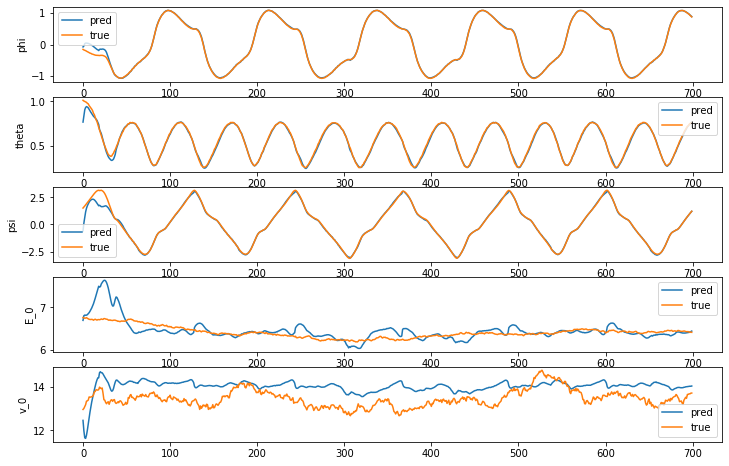

In [291]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_i.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')